<a href="https://colab.research.google.com/github/byunsy/brain-mri-segmentation/blob/main/Brain_MRI_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain MRI Segmentation


## 01. Import Necessary Packages

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import cv2
from skimage import io

In [3]:
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K

In [4]:
import random
import glob
from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display

## 02. Attain Dataset from Kaggle

In [5]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [7]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [8]:
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

 99% 708M/714M [00:06<00:00, 123MB/s]
100% 714M/714M [00:06<00:00, 113MB/s]


In [10]:
!unzip /content/lgg-mri-segmentation.zip

Streaming output truncated to the last 5000 lines.
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_13.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_1

## 03. Understanding the Dataset

In [11]:
base_dir = "/content/kaggle_3m"

In [12]:
!rm -r /content/lgg-mri-segmentation

In [13]:
data_map = []

for sub_dir_path in glob.glob(os.path.join(base_dir, "*")):

    try:
        dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + '/' + filename
            data_map.extend([dir_name, image_path])

    except Exception as e:
        print(e)

[Errno 20] Not a directory: '/content/kaggle_3m/data.csv'
[Errno 20] Not a directory: '/content/kaggle_3m/README.md'


In [14]:
data_map[:20]

['TCGA_DU_7306_19930512',
 '/content/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_29.tif',
 'TCGA_DU_7306_19930512',
 '/content/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_36.tif',
 'TCGA_DU_7306_19930512',
 '/content/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_40_mask.tif',
 'TCGA_DU_7306_19930512',
 '/content/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_3_mask.tif',
 'TCGA_DU_7306_19930512',
 '/content/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_13_mask.tif',
 'TCGA_DU_7306_19930512',
 '/content/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_35_mask.tif',
 'TCGA_DU_7306_19930512',
 '/content/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_41.tif',
 'TCGA_DU_7306_19930512',
 '/content/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_28.tif',
 'TCGA_DU_7306_19930512',
 '/content/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_10_mask.tif',
 'TCGA_DU_7306_19930512',
 '/content/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU

In [15]:
df = pd.DataFrame({"patient_id" : data_map[::2],
                   "path" : data_map[1::2]})
df

,patient_id,path
0,TCGA_DU_7306_19930512,/content/kaggle_3m/TCGA_DU_7306_19930512/TCGA_...
1,TCGA_DU_7306_19930512,/content/kaggle_3m/TCGA_DU_7306_19930512/TCGA_...
2,TCGA_DU_7306_19930512,/content/kaggle_3m/TCGA_DU_7306_19930512/TCGA_...
3,TCGA_DU_7306_19930512,/content/kaggle_3m/TCGA_DU_7306_19930512/TCGA_...
4,TCGA_DU_7306_19930512,/content/kaggle_3m/TCGA_DU_7306_19930512/TCGA_...
...,...,...
7853,TCGA_DU_5854_19951104,/content/kaggle_3m/TCGA_DU_5854_19951104/TCGA_...
7854,TCGA_DU_5854_19951104,/content/kaggle_3m/TCGA_DU_5854_19951104/TCGA_...
7855,TCGA_DU_5854_19951104,/content/kaggle_3m/TCGA_DU_5854_19951104/TCGA_...
7856,TCGA_DU_5854_19951104,/content/kaggle_3m/TCGA_DU_5854_19951104/TCGA_...


In [16]:
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

In [17]:
print(len(df_imgs))
print(len(df_masks))

3929
3929


In [18]:
data_map[:5]

['TCGA_DU_7306_19930512',
 '/content/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_29.tif',
 'TCGA_DU_7306_19930512',
 '/content/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_36.tif',
 'TCGA_DU_7306_19930512']

In [19]:
len("/content/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_")

63

In [20]:
# File path line length images for later sorting
BASE_LEN = 63 
END_IMG_LEN = 4 
END_MASK_LEN = 9

# Data sorting
imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

In [21]:
# Final dataframe
brain_df = pd.DataFrame({"patient_id": df_imgs.patient_id.values,
                         "image_path": imgs,
                         "mask_path": masks})

# Determines whether the mask has pixels in them
# - some will be blank black images
# - while some will have white pixels
def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : 
        return 1
    else:
        return 0
    

brain_df['mask'] = brain_df['mask_path'].apply(lambda x: pos_neg_diagnosis(x))
brain_df

,patient_id,image_path,mask_path,mask
0,TCGA_DU_7306_19930512,/content/kaggle_3m/TCGA_DU_7306_19930512/TCGA_...,/content/kaggle_3m/TCGA_DU_7306_19930512/TCGA_...,0
1,TCGA_DU_7306_19930512,/content/kaggle_3m/TCGA_DU_8167_19970402/TCGA_...,/content/kaggle_3m/TCGA_DU_8167_19970402/TCGA_...,0
2,TCGA_DU_7306_19930512,/content/kaggle_3m/TCGA_FG_6692_20020606/TCGA_...,/content/kaggle_3m/TCGA_FG_6692_20020606/TCGA_...,0
3,TCGA_DU_7306_19930512,/content/kaggle_3m/TCGA_HT_7879_19981009/TCGA_...,/content/kaggle_3m/TCGA_HT_7879_19981009/TCGA_...,0
4,TCGA_DU_7306_19930512,/content/kaggle_3m/TCGA_DU_8164_19970111/TCGA_...,/content/kaggle_3m/TCGA_DU_8164_19970111/TCGA_...,0
...,...,...,...,...
3924,TCGA_DU_5854_19951104,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,0
3925,TCGA_DU_5854_19951104,/content/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_...,/content/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_...,0
3926,TCGA_DU_5854_19951104,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,0
3927,TCGA_DU_5854_19951104,/content/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_...,/content/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_...,0


## 04. Data Exploration and Visualization

In [22]:
brain_df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

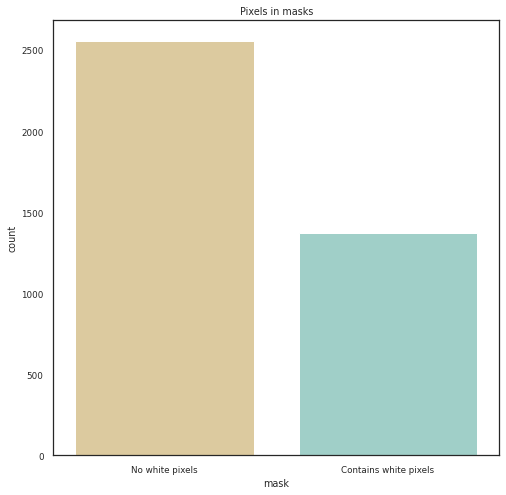

In [29]:
sns.set(rc={ 'figure.figsize':(8.0, 8.0) }, style='white', font_scale=0.8)
sns.countplot(x='mask', data=brain_df, palette='BrBG')

plt.title('Pixels in masks')
plt.xticks(ticks=[0, 1], labels=['No white pixels', 'Contains white pixels'])

plt.show()

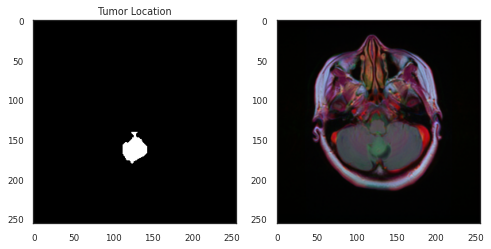

In [27]:
# Traverse and select the first mri scan that has a valid mask 
for i in range(len(brain_df)):
    if cv2.imread(brain_df.mask_path[i]).max() > 0:
        break

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(cv2.imread(brain_df.mask_path[i]));
plt.title('Tumor Location')

plt.subplot(1,2,2)
plt.imshow(cv2.imread(brain_df.image_path[i]));